In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

import random
from random import sample
import seaborn as sns

from netgraph import Graph

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import itertools

In [2]:
# let's try to use this twitter dataset
# it's in data/congress-twitter
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10493874/

def load_congress_data_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    data = data[0]

    inList = data['inList']
    inWeight = data['inWeight']
    outList = data['outList']
    outWeight = data['outWeight']
    usernameList = data['usernameList']

    return inList, inWeight, outList, outWeight, usernameList

def create_congress_graph(inList, inWeight, outList, outWeight, usernameList):
    G = nx.DiGraph()
    for i, username in enumerate(usernameList):
        G.add_node(i, username=username)
    for i in range(len(inList)):
        for j, in_node in enumerate(inList[i]):
            G.add_edge(in_node, i, weight=inWeight[i][j])
        for j, out_node in enumerate(outList[i]):
            G.add_edge(i, out_node, weight=outWeight[i][j])
    return G

In [3]:
inList, inWeight, outList, outWeight, usernameList = load_congress_data_from_json('data/congress-twitter/congress_network_data.json')
G = create_congress_graph(inList, inWeight, outList, outWeight, usernameList)
print(G)

DiGraph with 475 nodes and 13289 edges


In [29]:
# 1 is democrat, -1 is republican, 0 is other
for node, party in zip(G.nodes(), encoded_parties):
  G.nodes[node]['party'] = party

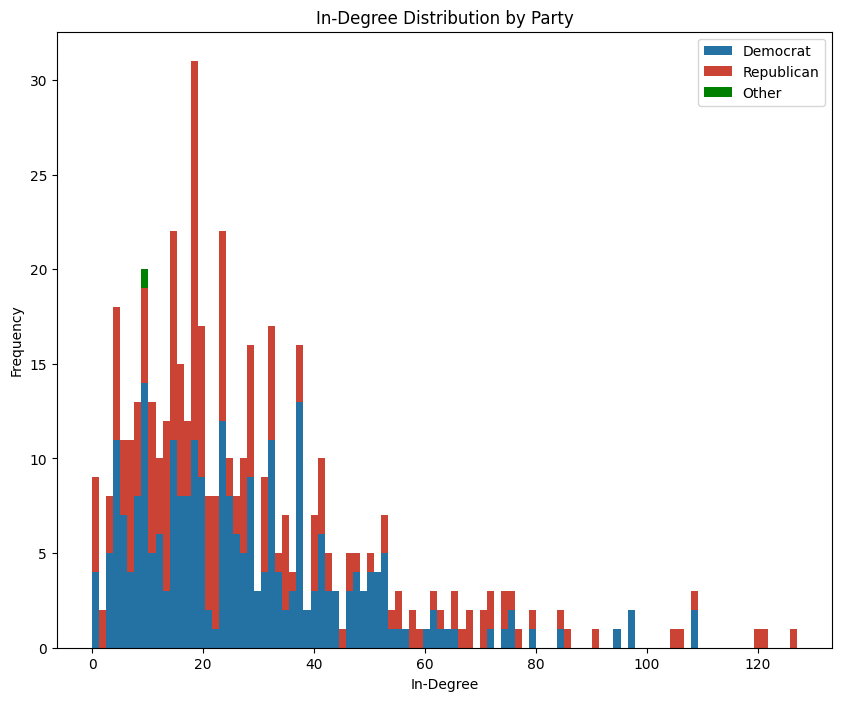

In [51]:
# dictionary for degrees by party
in_degrees_by_party = defaultdict(list)

# categorize degrees by party
for n in G.nodes():
    party = G.nodes[n]['party']
    in_degrees_by_party[party].append(G.in_degree(n))

bins = 100
colors = {1: '#2471a3', 0: 'green', -1: '#cb4335'}
hist_data = []
hist_colors = []

# create histogram data for each party
for party, degrees in in_degrees_by_party.items():
    hist_data.append(degrees)
    hist_colors.append(colors[party])

# plot stacked histogram
plt.figure(figsize=(10, 8))
plt.hist(hist_data, bins=bins, stacked=True, color=hist_colors)
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.title('In-Degree Distribution by Party')
plt.legend(['Democrat', 'Republican', 'Other'])
plt.savefig('fig/in_degree_distribution_by_party.png', bbox_inches='tight')
plt.show()

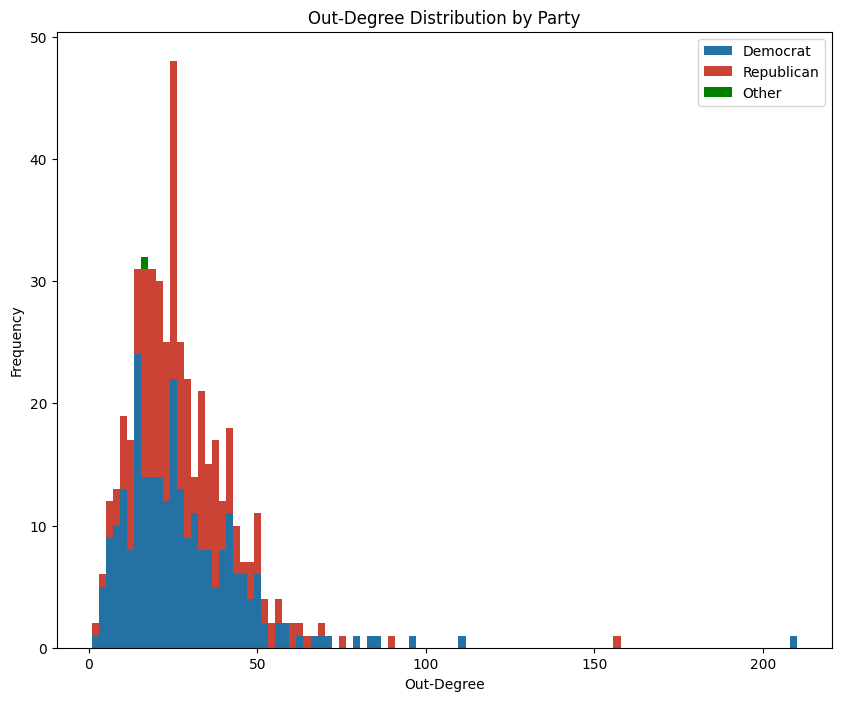

In [49]:
# dictionary for degrees by party
out_degrees_by_party = defaultdict(list)

# categorize degrees by party
for n in G.nodes():
    party = G.nodes[n]['party']
    out_degrees_by_party[party].append(G.out_degree(n))

bins = 100
colors = {1: '#2471a3', 0: 'green', -1: '#cb4335'}
hist_data = []
hist_colors = []

# create histogram data for each party
for party, degrees in out_degrees_by_party.items():
    hist_data.append(degrees)
    hist_colors.append(colors[party])

# plot stacked histogram
plt.figure(figsize=(10, 8))
plt.hist(hist_data, bins=bins, stacked=True, color=hist_colors)
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.title('Out-Degree Distribution by Party')
plt.legend(['Democrat', 'Republican', 'Other'])
plt.savefig('fig/out_degree_distribution_by_party.png', bbox_inches='tight')
plt.show()

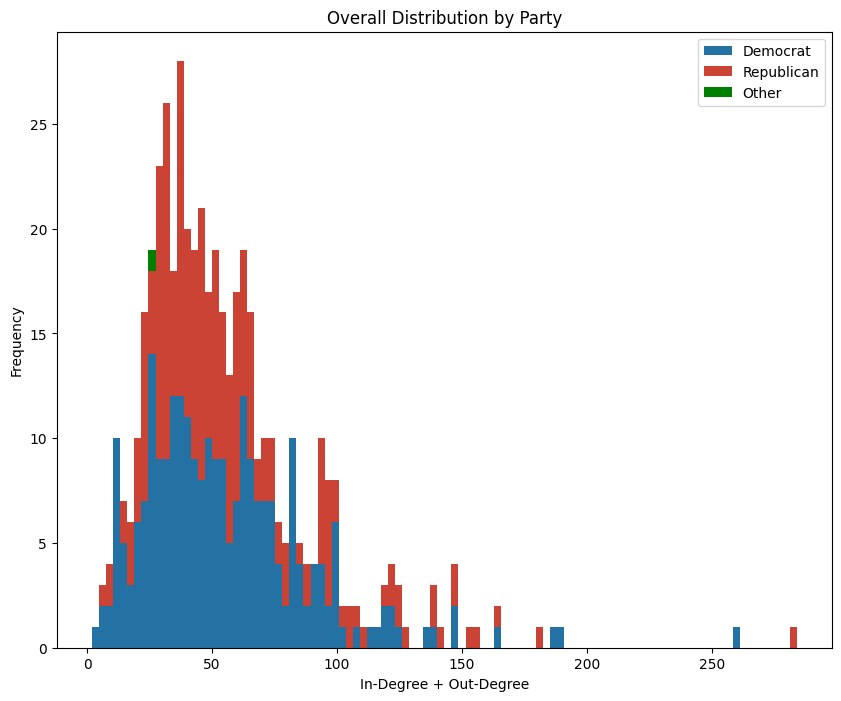

In [50]:
# dictionary for degrees by party
overall_degrees_by_party = defaultdict(list)

# categorize degrees by party
for n in G.nodes():
    party = G.nodes[n]['party']
    overall_degrees_by_party[party].append(G.degree(n))

bins = 100
colors = {1: '#2471a3', 0: 'green', -1: '#cb4335'}
hist_data = []
hist_colors = []

# create histogram data for each party
for party, degrees in overall_degrees_by_party.items():
    hist_data.append(degrees)
    hist_colors.append(colors[party])

# plot stacked histogram
plt.figure(figsize=(10, 8))
plt.hist(hist_data, bins=bins, stacked=True, color=hist_colors)
plt.xlabel('In-Degree + Out-Degree')
plt.ylabel('Frequency')
plt.title('Overall Distribution by Party')
plt.legend(['Democrat', 'Republican', 'Other'])
plt.savefig('fig/overall_degree_distribution_by_party.png', bbox_inches='tight')
plt.show()

In [196]:
# try implementing model from the community detection paper
def community_detection(G, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(x[Ni_confidence] - x[i])

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [197]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    x0 = np.random.rand(n) # generate random opinions
    print('x0 =', x0) # in the future, let's use political party as initial opinion
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    print('Ni_0 =', Ni)

    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))

        print('x =', x)
        print('computed new opinions')
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            print('x =', x)
            break
        # update rho 
        # rho *= rho
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    return communities_list

In [153]:
def to_hex_string(color):
    if color == 'blue':
        return '#2471a3'
    elif color == 'red':
        return '#cb4335'
colors = ['blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'red']
colors = [to_hex_string(color) for color in colors]
colors

['#2471a3',
 '#cb4335',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#cb4335',
 '#2471a3',
 '#2471a3',
 '#cb4335']

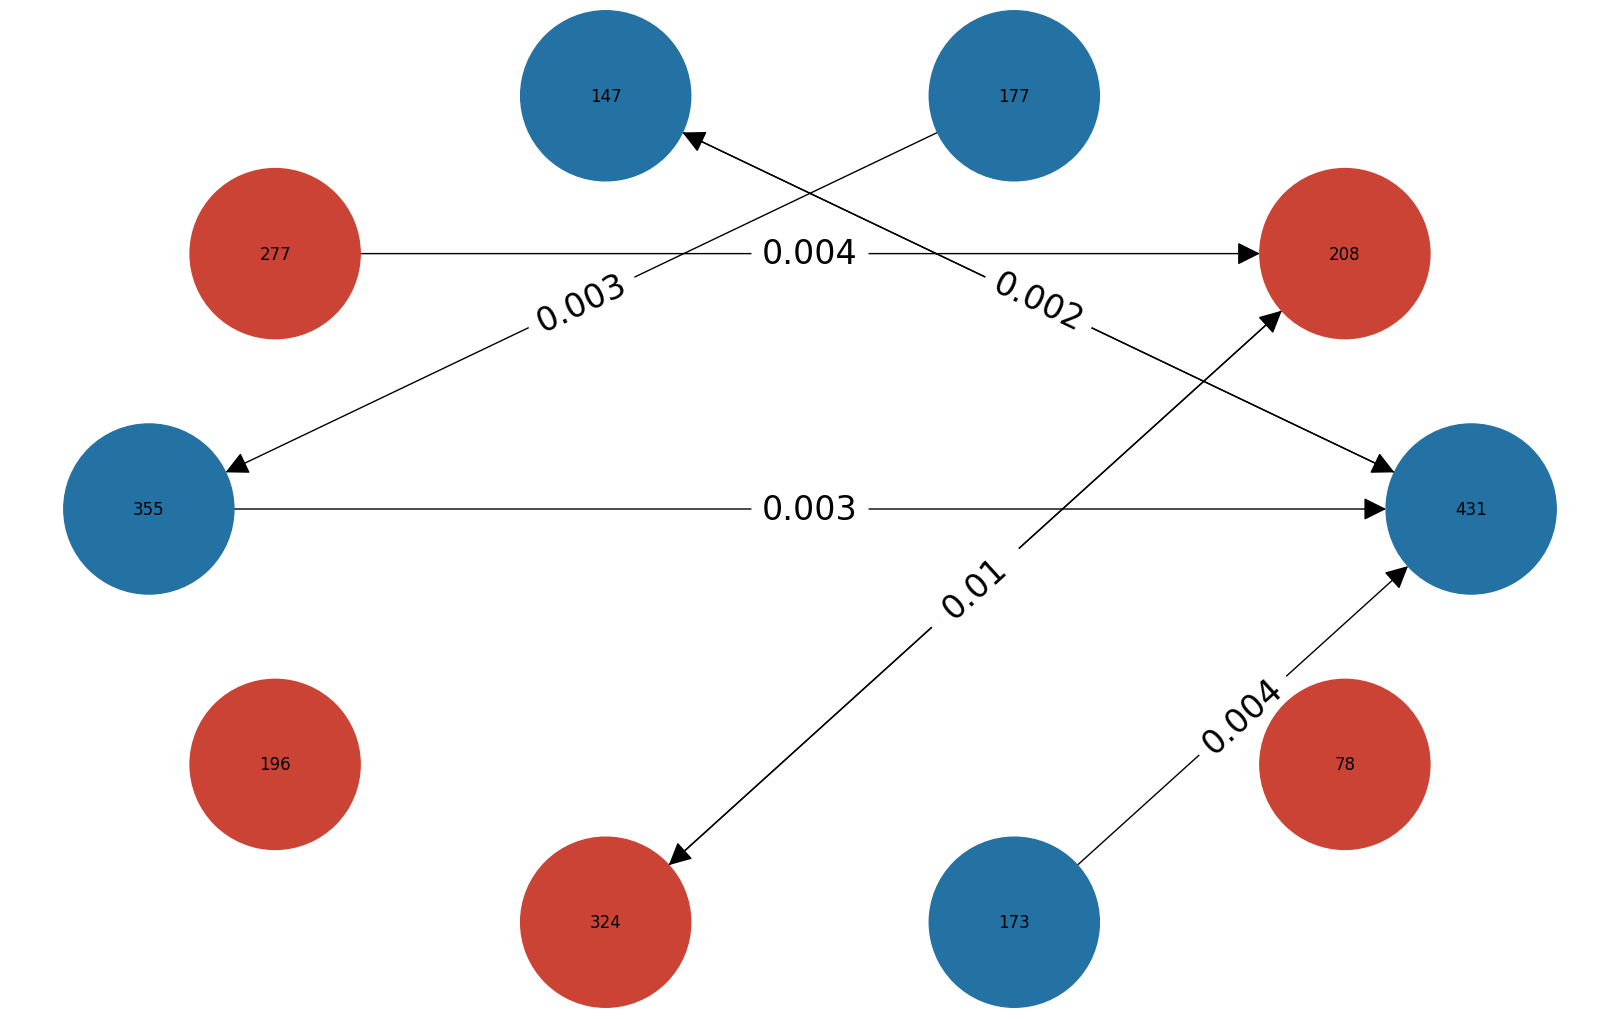

In [165]:
edge_weights = nx.get_edge_attributes(subgraph, 'weight')
rounded_edge_weights = {key: round(value, 3) for key, value in edge_weights.items()}
fig = plt.figure(figsize=(16, 10))
nx.draw_shell(subgraph, node_size=15000, arrowsize=35, node_color=colors, with_labels=True)
nx.draw_networkx_edge_labels(subgraph, pos=nx.shell_layout(subgraph), edge_labels=rounded_edge_weights, font_size=24)
plt.savefig('figs/ex.png')

In [183]:
usernameList
with open('data/parties.json', 'r') as file:
    data = json.load(file)
parties = [item['party'] for item in data]
encoded_parties = [1 if party == 'D' else -1 if party == 'R' else 0 for party in parties]
# sanity check
assert (len([i for i, party in enumerate(encoded_parties) if party == -1]) + len([i for i, party in enumerate(encoded_parties) if party == 1]) + len([i for i, party in enumerate(encoded_parties) if party == 0])) == len(encoded_parties)

def generate_initial_opinions_parties(p):
    x0 = []
    for i in range(len(p)):
        if p[i] == 1:
            x0.append(np.random.uniform(0, 1))
        elif p[i] == -1:
            x0.append(np.random.uniform(-1, 0))
        else:
            x0.append(np.random.uniform(-1, 1))
    return np.array(x0)

In [185]:
# try implementing model from the community detection paper
def community_detection_weighted(G, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    if with_parties:
        x0 = generate_initial_opinions_parties(encoded_parties) # use party opinions
    else:
        x0 = np.random.rand(n) # generate random opinions
    # print('x0 =', x0)
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    # print('starting iterations')
    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))
        # if t % 1000 == 0:
            # print('t =', t)
            # print('x =', x)
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            break
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    # print('communities_list =', communities_list)

    node_to_community = {}
    for i, community in enumerate(communities_list):
        for node in community:
            node_to_community[node] = i
    # print('node_communities =', node_to_community)
    return x, node_to_community

In [201]:
small_subgraph = G.subgraph(sample(list(G.nodes()), 20))
opinions, node_to_community = community_detection_weighted(small_subgraph, with_parties=True, alpha=0.1, R=1.0, delta=0.001)

converged at t = 15860


In [202]:
num_communities = len(set(node_to_community.values()))
num_communities

459

In [54]:
delta_grid = np.linspace(0.01, 0.5, 50)
results = []
for delta in delta_grid:
    xs, node_to_community = community_detection_weighted(G, with_parties=True, delta=delta)
    unique_communities = set(node_to_community.values())
    print('finished delta =', delta, 'with', len(unique_communities), 'unique communities')
    results.append(
        {
            'delta': delta,
            'xs': xs.tolist(),
            'node_to_community': [node_to_community[i] for i in range(len(node_to_community))]
        }
    )

with open('results/delta_grid.json', 'w') as file:
    json.dump(results, file)

KeyboardInterrupt: 

In [207]:
results = json.load(open('results/delta_grid.json', 'r'))
results

[{'delta': 0.01,
  'xs': [0.49847116135873315,
   -0.4827471887941287,
   0.49847116138426717,
   -0.4863849588420458,
   0.49847116136611186,
   -0.4794331015336929,
   0.4984711613845248,
   -0.4827471887941448,
   -0.4794331015337836,
   0.4984711613298617,
   0.4984711614042716,
   -0.4794331015336481,
   0.4984711611759705,
   0.49847116137657993,
   0.5180054518521665,
   -0.486384958841885,
   0.49847116136470565,
   -0.48638495884203686,
   0.4984711615211445,
   -0.48274718879414247,
   -0.48531717618908227,
   -0.48274718879413464,
   -0.47943310153387053,
   -0.48638495884198174,
   0.4984711613566431,
   0.49847116135065844,
   -0.4794331015335434,
   0.49847116136874736,
   -0.4768495966218307,
   0.49847116132109026,
   -0.47943310153377083,
   -0.4794331015335782,
   -0.48638495884203947,
   0.4984711615278809,
   -0.4794331015338426,
   0.49847116143091175,
   0.498471161386568,
   0.49847116136989605,
   -0.485317176189084,
   -0.48532246699762965,
   -0.47943310153368

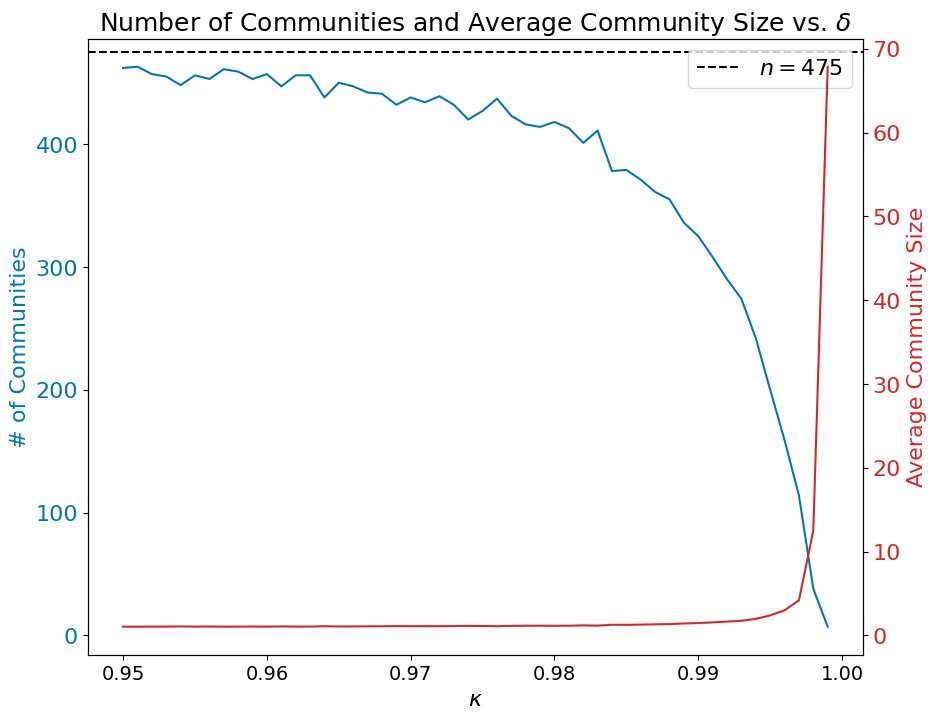

In [271]:
num_communities = []
for result in results:
    num_communities.append(len(set(result['node_to_community'])))

average_community_sizes = []
for result in results:
    community_sizes = [result['node_to_community'].count(i) for i in range(len(set(result['node_to_community'])))]
    average_community_sizes.append(np.mean(community_sizes))

blue = '#0076BA'
red = 'tab:red'

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax1.xaxis.set_major_locator(MultipleLocator(0.05))
# ax1.xaxis.set_minor_locator(MultipleLocator(0.01))
ax1.set_xlabel('$\\kappa$', fontsize=16)
ax1.set_ylabel('# of Communities', color=blue, fontsize=16)
ax1.plot(1 - 0.1*delta_grid, num_communities, color=blue)
ax1.tick_params(axis='y', labelcolor='#0076BA', labelsize=16)
ax1.axhline(y=len(results[0]['xs']), color='black', linestyle='--', label='$n=475$')

ax2 = ax1.twinx()

ax2.set_ylabel('Average Community Size', color=red, fontsize=16)
ax2.plot(1 - 0.1*delta_grid, average_community_sizes, color=red)
ax2.tick_params(axis='y', labelcolor=red, labelsize=16)

ax1.legend(loc='upper right', fontsize=16)
ax1.set_title('Number of Communities and Average Community Size vs. $\\kappa$', fontsize=18)
plt.savefig('results/figs/delta_grid.png')
plt.show()

In [57]:
def draw_community_graph(G, x, node_to_community, orientation='horizontal'):
    if isinstance(node_to_community, dict):
      unique_communities = set(node_to_community.values())
    else:
      unique_communities = set(node_to_community)
    if len(unique_communities) <= 10:
      community_to_color = {
          0: 'tab:blue',
          1: 'tab:red',
          2: 'tab:green',
          3: 'tab:orange',
          4: 'tab:purple',
          5: 'tab:brown',
          6: 'tab:pink',
          7: 'tab:gray',
          8: 'tab:olive',
          9: 'tab:cyan'
      }
      if isinstance(node_to_community, dict):
        node_color = {node: community_to_color[node_to_community[node]] for node in node_to_community.keys()}
    else:
      node_color = None

    if orientation == 'horizontal':
      scale = (2, 1)
    elif orientation == 'vertical':
      scale = (1, 2)
    else:
      scale = (2, 2)

    fig = plt.figure(figsize=(10, 11))
    Graph(G,
          node_color=node_color, node_edge_width=0, edge_alpha=0.7,
          node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
          edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
          scale=scale
    )
    fig.set_facecolor('white')
    plt.savefig('results/figs/community_graph.png')

    plt.show()

In [58]:
table_indices = [0, 1, 2, 3, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49]
table_results = [results[i] for i in table_indices]

table_node_to_community = [result['node_to_community'] for result in table_results]
table_deltas = [result['delta'] for result in table_results]
table_xs = [result['xs'] for result in table_results]

table_num_communities = [len(set(result['node_to_community'])) for result in table_results]
table_average_community_sizes = [np.mean([result['node_to_community'].count(i) for i in range(len(set(result['node_to_community'])))]) for result in table_results]

opinion_disparities = {}
opinion_disparities_list = []

for param_index, communities in enumerate(table_node_to_community):
    temp_dict = {}
    community_groups = [[i for i, x in enumerate(communities) if x == j] for j in range(max(communities) + 1)]
    for community_index, community_indices in enumerate(community_groups):
        community_opinions = [table_xs[param_index][i] for i in community_indices]
        mean_opinion = sum(community_opinions) / len(community_opinions)
        # if param_index == 0:
        #     print('mean_opinion =', mean_opinion)
        temp_dict[community_index] = mean_opinion

    temp_list = []
    for pair in itertools.combinations(temp_dict.keys(), 2):
        opinion_disparities[(param_index, pair)] = abs(temp_dict[pair[0]] - temp_dict[pair[1]])
        temp_list.append(abs(temp_dict[pair[0]] - temp_dict[pair[1]]))

    opinion_disparities_list.append(temp_list)

mean_opinion_disparities = []
median_opinion_disparities = []
max_opinion_disparities = []
min_opinion_disparities = []
std_opinion_disparities = []
for param_index in range(len(table_results)):
    mean_opinion_disparities.append(np.mean([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    median_opinion_disparities.append(np.median([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    max_opinion_disparities.append(np.max([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    min_opinion_disparities.append(np.min([value for key, value in opinion_disparities.items() if key[0] == param_index]))
    std_opinion_disparities.append(np.std([value for key, value in opinion_disparities.items() if key[0] == param_index]))
print(mean_opinion_disparities)

table = pd.DataFrame({
    '$\\delta$': table_deltas,
    '# of Communities': table_num_communities,
    'Average Community Size': table_average_community_sizes,
    'Opinion Disparities': opinion_disparities_list,
    'Mean Opinion Disparity': mean_opinion_disparities,
    'Median Opinion Disparity': median_opinion_disparities,
    'Max Opinion Disparity': max_opinion_disparities,
    'Min Opinion Disparity': min_opinion_disparities,
    'Std Opinion Disparity': std_opinion_disparities
})
table

[0.47491905088454395, 0.5045198631888197, 0.4846882040841204, 0.5316355760641527, 0.5721737618983963, 0.6069570730111064, 0.6099390077554854, 0.6283310073798476, 0.6416507263111526, 0.6396734356415681, 0.6308986084478451, 0.6428275076482318, 0.6407500866979032, 0.6488065652056887]


,$\delta$,# of Communities,Average Community Size,Opinion Disparities,Mean Opinion Disparity,Median Opinion Disparity,Max Opinion Disparity,Min Opinion Disparity,Std Opinion Disparity
0,0.01,7,67.857143,"[0.9779038637615882, 0.981218350132112, 0.9848...",0.474919,0.019534,1.004390,0.001066,0.491543
1,0.02,38,12.500000,"[0.9762983030865096, 0.9765270766865621, 0.975...",0.504520,0.281155,1.318031,0.000087,0.471988
2,0.03,114,4.166667,"[0.0011359237231950425, 1.0160009263157637, 0....",0.484688,0.176102,1.444223,0.000065,0.474368
3,0.04,159,2.987421,"[0.00649551810963328, 1.0077554295318802, 1.08...",0.531636,0.337757,1.514896,0.000107,0.439462
4,0.05,200,2.375000,"[0.16639842596681714, 1.0383558990751485, 1.09...",0.572174,0.497006,1.665468,0.000109,0.441367
5,0.10,325,1.461538,"[0.511673384580301, 0.6624241278648427, 0.3261...",0.606957,0.522461,1.823754,0.000112,0.439713
6,0.15,379,1.253298,"[0.47109044481348755, 0.9901150222487298, 1.10...",0.609939,0.528421,1.851488,0.000120,0.437420
7,0.20,418,1.136364,"[0.9267338899648272, 0.06536865844013584, 0.25...",0.628331,0.550031,1.880970,0.000102,0.447695
8,0.25,427,1.112412,"[0.15731776155980554, 0.05375857678713414, 0.2...",0.641651,0.561973,1.881441,0.000103,0.457381
9,0.30,438,1.084475,"[0.6524756826401064, 0.4836108846481697, 0.025...",0.639673,0.559042,1.939591,0.000114,0.453631


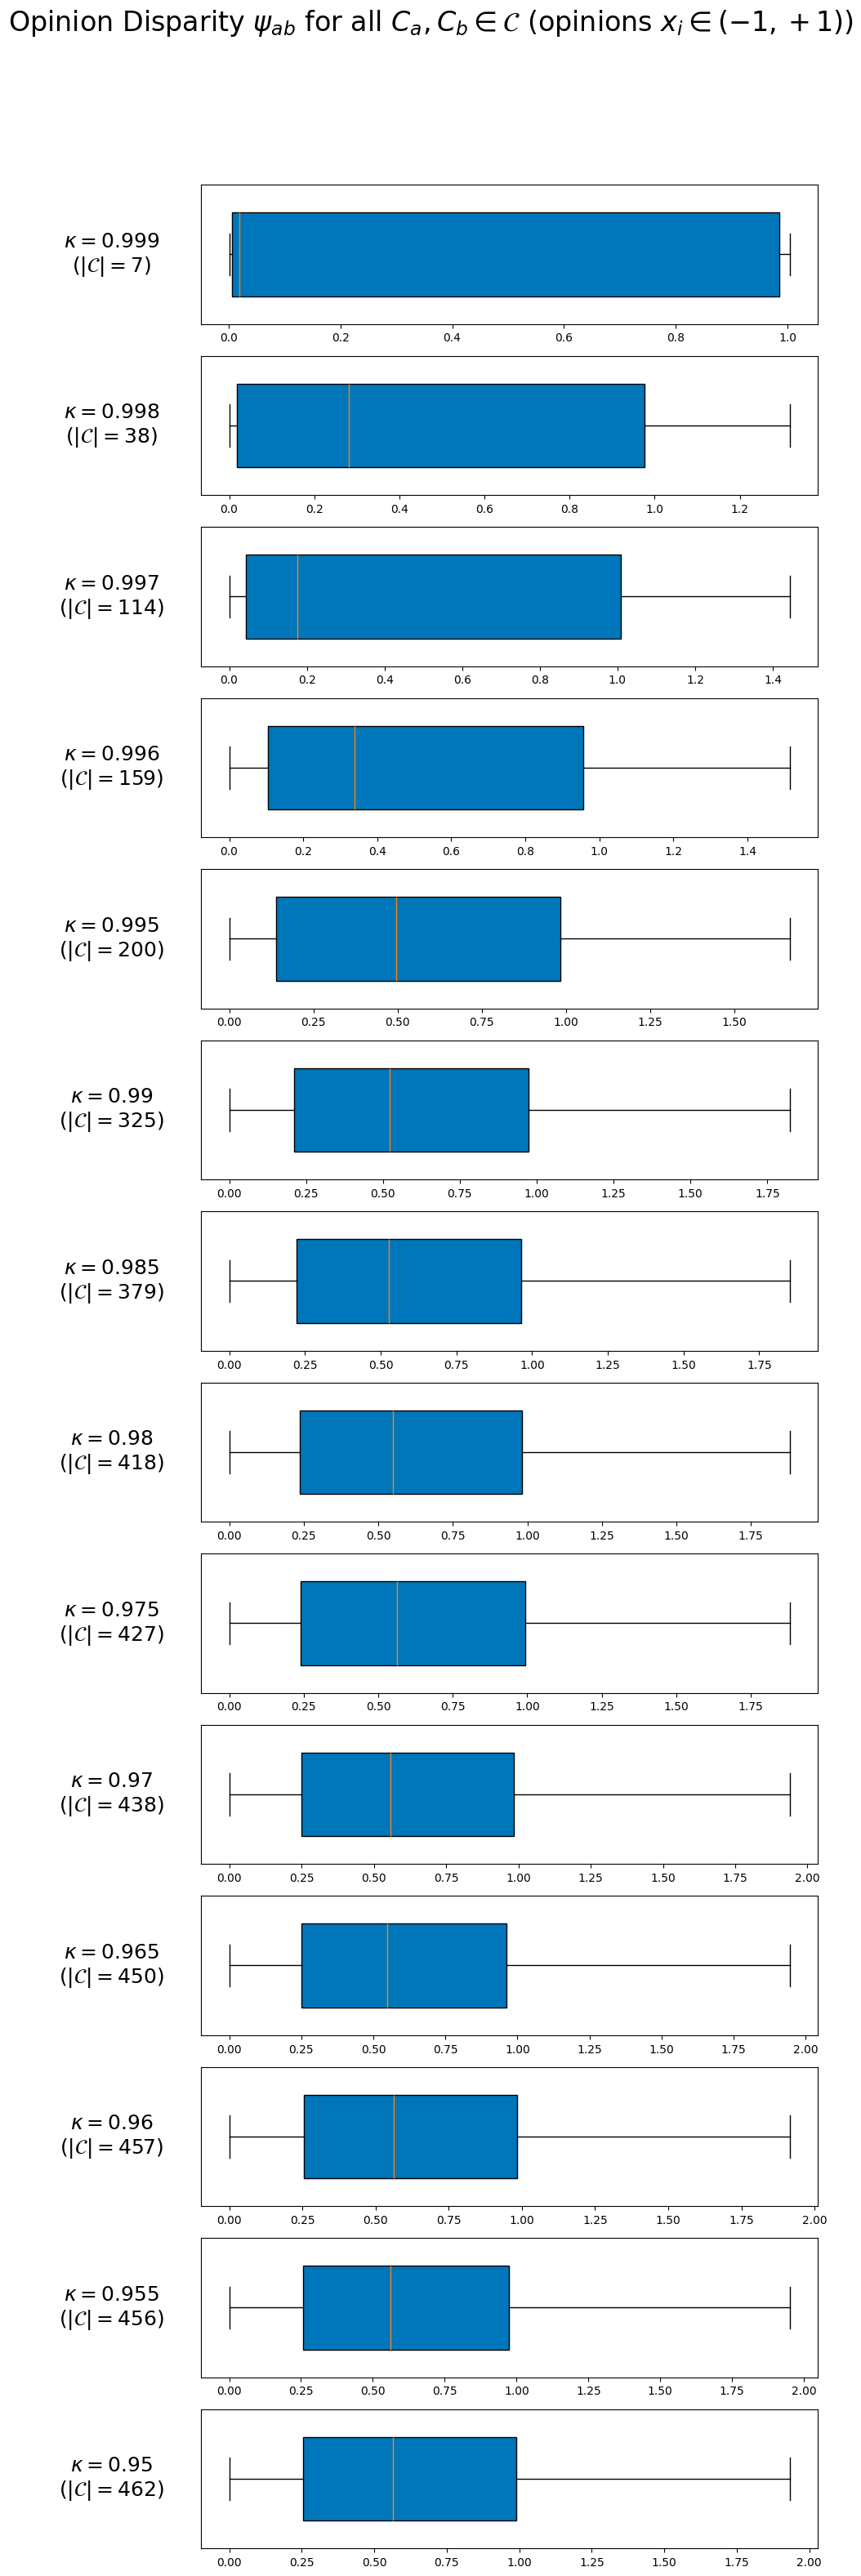

In [267]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(10, 30))
gs = gridspec.GridSpec(len(opinion_disparities_list), 2, width_ratios=[1, 4])


for i, disparities in enumerate(opinion_disparities_list):
    # Text subplot
    ax_text = fig.add_subplot(gs[i, 0])
    ax_text.text(0.5, 0.5, '$\\kappa = ' + str(round(1 - 0.1*table_deltas[i], 3)) + '$\n' '$\\left(|\\mathcal{C}|= ' + str(table_num_communities[i]) + '\\right)$', fontsize=18, va='center', ha='center')
    ax_text.axis('off')

    # Boxplot subplot
    ax_boxplot = fig.add_subplot(gs[i, 1])
    bp = ax_boxplot.boxplot(disparities, vert=False, patch_artist=True, widths=0.6)
    for box in bp['boxes']:
        box.set(facecolor='#0076BA')
    ax_boxplot.set_yticks([])
    ax_boxplot.tick_params(axis='x')  # Adjust x-axis tick params

fig.suptitle('Opinion Disparity $\\psi_{ab}$ for all $C_a, C_b\in\\mathcal{C}$ (opinions $x_i\in (-1,+1)$)', fontsize=24, y=1.05)
plt.subplots_adjust(top=0.2)

plt.savefig('fig/opinion_disparities_boxplot.png')
plt.show()


DiGraph with 100 nodes and 716 edges


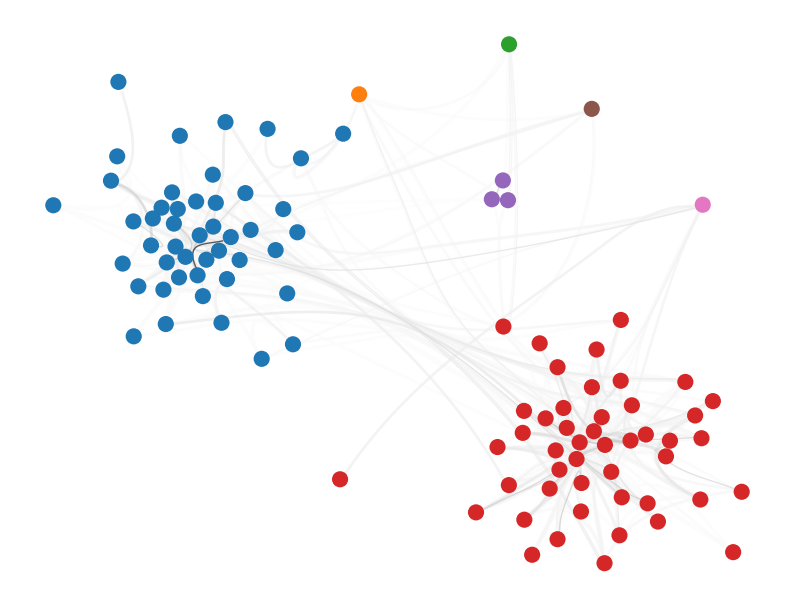

459

In [206]:
subgraph = G.subgraph(random.sample(list(G.nodes()), 100))
sampled_results = results[0]
sampled_node_to_community = {node: community for node, community in enumerate(sampled_results['node_to_community'])}
sampled_xs = sampled_results['xs']
print(subgraph)
draw_community_graph(subgraph, sampled_xs, sampled_node_to_community, orientation='square')
num_communities = len(set(node_to_community.values()))
num_communities

# Opinion Initializations

In [148]:
blue = '#2471a3'
red = '#cb4335'

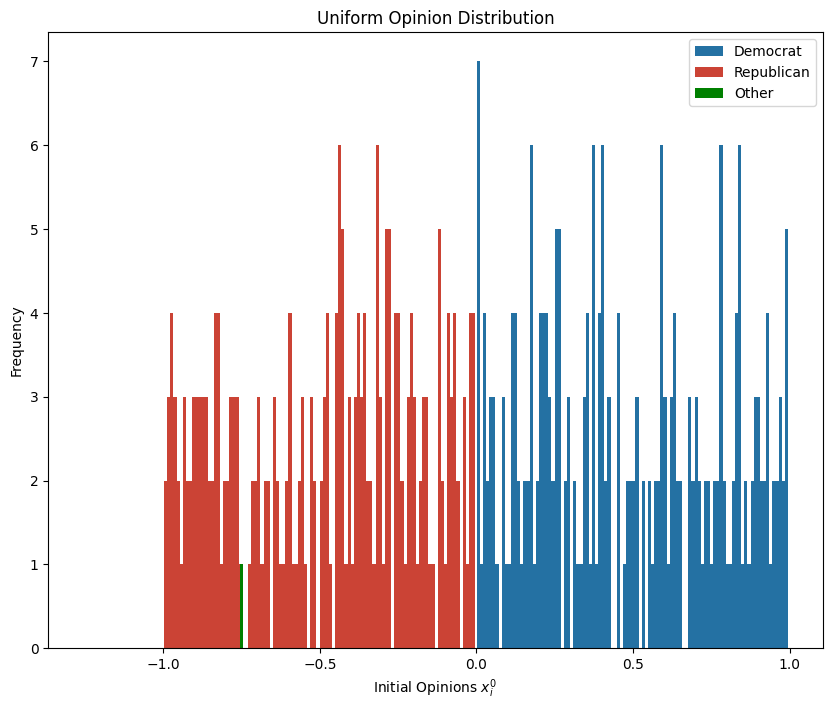

In [152]:
dem_array = np.random.uniform(0, 1, size=(len(G.nodes)//2,))
rep_array = np.random.uniform(-1, 0, size=(len(G.nodes)//2,))

# plot
plt.figure(figsize=(10, 8))
plt.hist(dem_array, bins=100, color=blue)
plt.hist(rep_array, bins=100, color=red)
plt.hist(ind_array, bins=100, color='green')
plt.xlabel('Initial Opinions $x_i^0$')
plt.ylabel('Frequency')
plt.title('Uniform Opinion Distribution')
plt.legend(['Democrat', 'Republican', 'Other'])
plt.savefig('fig/uniform_opinion_distribution.png', bbox_inches='tight')
plt.show()

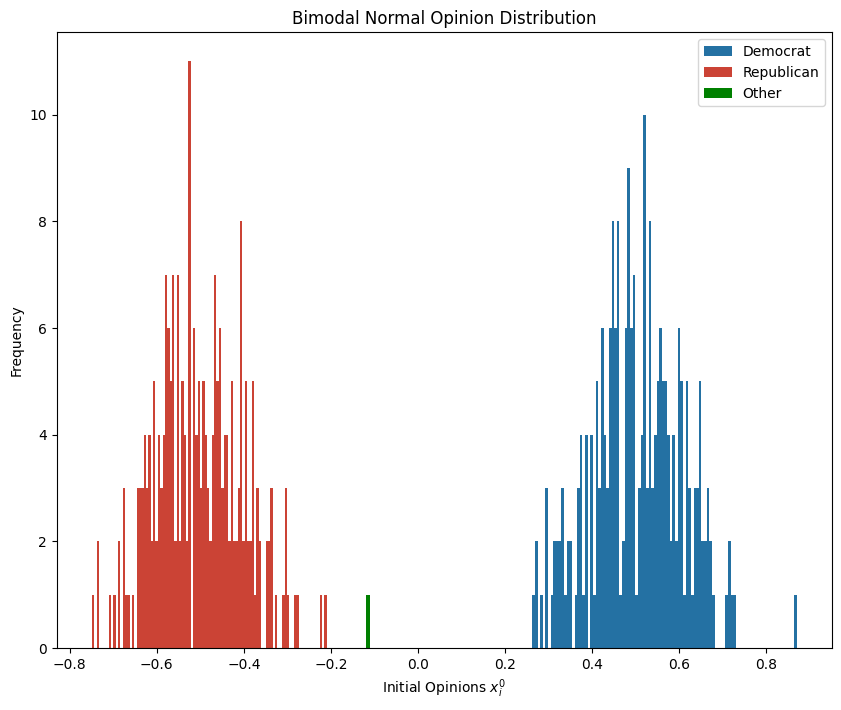

In [153]:
# create normal distribution array
dem_array = np.random.normal(0.5, 0.1, size=(len(G.nodes)//2,))
rep_array = np.random.normal(-0.5, 0.1, size=(len(G.nodes)//2,))
ind_array = np.random.normal(0, 0.1, size=(1,))

# plot
plt.figure(figsize=(10, 8))
plt.hist(dem_array, bins=100, color=blue)
plt.hist(rep_array, bins=100, color=red)
plt.hist(ind_array, bins=100, color='green')
plt.xlabel('Initial Opinions $x_i^0$')
plt.ylabel('Frequency')
plt.title('Bimodal Normal Opinion Distribution')
plt.legend(['Democrat', 'Republican', 'Other'])
plt.savefig('fig/bimodal_normal_opinion_distribution.png', bbox_inches='tight')
plt.show()

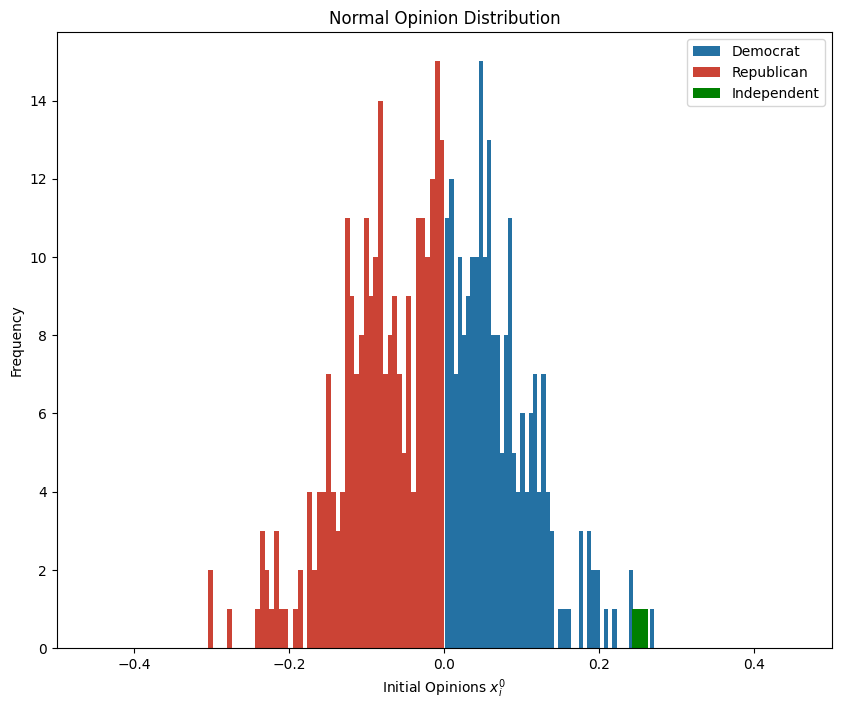

In [182]:
# create normal distribution array
full_values = np.random.normal(0, 0.1, size=(len(G.nodes),))

dem_values = full_values[full_values >= 0]
rep_values = full_values[full_values < 0]
ind_values = np.array([0.24232])

plt.figure(figsize=(10, 8))

plt.hist(dem_values, bins=50, color=blue)
plt.hist(rep_values, bins=50, color=red)
plt.hist(ind_values, bins=50, color='green')
plt.xlim(-0.5, 0.5)
plt.xlabel('Initial Opinions $x_i^0$')
plt.ylabel('Frequency')
plt.title('Normal Opinion Distribution')
plt.legend(['Democrat', 'Republican', 'Independent'])
plt.savefig('fig/normal_opinion_distribution.png', bbox_inches='tight')
plt.show()

# Initialization Experiments

In [208]:
usernameList
with open('data/parties.json', 'r') as file:
    data = json.load(file)
parties = [item['party'] for item in data]
encoded_parties = [1 if party == 'D' else -1 if party == 'R' else 0 for party in parties]
# sanity check
assert (len([i for i, party in enumerate(encoded_parties) if party == -1]) + len([i for i, party in enumerate(encoded_parties) if party == 1]) + len([i for i, party in enumerate(encoded_parties) if party == 0])) == len(encoded_parties)

def generate_initial_opinions_parties(p):
    x0 = []
    for i in range(len(p)):
        if p[i] == 1:
            x0.append(np.random.uniform(0, 1))
        elif p[i] == -1:
            x0.append(np.random.uniform(-1, 0))
        else:
            x0.append(np.random.uniform(-1, 1))
    return np.array(x0)

In [209]:
# try implementing model from the community detection paper
def community_detection_weighted_new(G, x0, with_parties=False, alpha=0.1, R=1.0, delta=0.1):
    n = len(G.nodes())
    # if with_parties:
    #     x0 = generate_initial_opinions_parties(encoded_parties) # use party opinions
    # else:
    #     x0 = np.random.rand(n) # generate random opinions
    # print('x0 =', x0)
    x = x0.copy()

    rho = 1 - alpha*delta # rho is convergence rate
    A = nx.to_numpy_array(G) # adjacency matrix
    A_normaized = A / np.max(A)

    Ni = [np.where(A[i]!=0)[0] for i in range(n)] # compute neighbor sets
    # print('starting iterations')
    t = 0
    while True:
        t += 1
        x_prev = x.copy()

        # update opinions 
        for i in range(n):
            Ni_confidence = [j for j in Ni[i] if abs(x[i] - x[j]) <= R*rho**t]
            if len(Ni_confidence) > 0:
                x[i] = x[i] + alpha * np.mean(A_normaized[i, Ni_confidence] * (x[Ni_confidence] - x[i]))
        # if t % 1000 == 0:
            # print('t =', t)
            # print('x =', x)
                    
        if np.max(np.abs(x - x_prev)) < 1e-12:
            print('converged at t =', t)
            break
    
    # generate final communities
    communities = {}
    for i, opinion in enumerate(x):
        for key in communities.keys():
            if abs(key - opinion) < 1e-4:
                communities[key].append(i)
                break
        else:
            communities[opinion] = [i]
    communities_list = list(communities.values())
    communities_list.sort(key=len, reverse=True)
    # print('communities_list =', communities_list)

    node_to_community = {}
    for i, community in enumerate(communities_list):
        for node in community:
            node_to_community[node] = i
    # print('node_communities =', node_to_community)
    return x, node_to_community

In [224]:
def uniform_initialized_opinions(party_affiliations):
    opinions = []
    for i in range(len(party_affiliations)):
        if party_affiliations[i] == 1:
            opinions.append(np.random.uniform(0, 1))
        elif party_affiliations[i] == -1:
            opinions.append(np.random.uniform(-1, 0))
        else:
            opinions.append(np.random.uniform(-1, 1))
    return np.array(opinions)

def normal_initialized_opinions(party_affiliations, mean=0, std_dev=0.1):
    opinions = []
    for party in party_affiliations:
        opinion = np.random.normal(mean, std_dev)
        opinion = opinion if (party == 1 and opinion > 0) or (party == -1 and opinion < 0) else opinion
        opinions.append(opinion)
    return np.array(opinions)

def bimodal_initialized_opinions(party_affiliations, mean=0.5, std_dev=0.1):
    opinions = []
    for i in range(len(party_affiliations)):
        if party_affiliations[i] == 1:
            opinions.append(np.random.normal(mean, std_dev))
        elif party_affiliations[i] == -1:
            opinions.append(np.random.normal(-mean, std_dev))
        else:
            opinions.append(np.random.normal(0, std_dev))
    return np.array(opinions)

In [225]:
uniform_x0 = uniform_initialized_opinions(encoded_parties)
normal_x0 = normal_initialized_opinions(encoded_parties)
bimodal_x0 = bimodal_initialized_opinions(encoded_parties)

uniform_results = community_detection_weighted_new(G, uniform_x0, with_parties=True, delta=0.01)
print('done with uniform')
normal_results = community_detection_weighted_new(G, normal_x0, with_parties=True, delta=0.01)
print('done with normal')
bimodal_results = community_detection_weighted_new(G, bimodal_x0, with_parties=True, delta=0.01)
print('done with bimodal')

uniform_node_to_community = uniform_results[1]
normal_node_to_community = normal_results[1]
bimodal_node_to_community = bimodal_results[1]

uniform_num_communities = len(set(uniform_node_to_community.values()))
normal_num_communities = len(set(normal_node_to_community.values()))
bimodal_num_communities = len(set(bimodal_node_to_community.values()))

converged at t = 20761
done with uniform
converged at t = 21016
done with normal
converged at t = 20705
done with bimodal


In [257]:
print('uniform_num_communities =', uniform_num_communities)
print('normal_num_communities =', normal_num_communities)
print('bimodal_num_communities =', bimodal_num_communities)

uniform_opinions = uniform_results[0]
normal_opinions = normal_results[0]
bimodal_opinions = bimodal_results[0]

uniform_opinion_disparities = {}
uniform_opinion_disparities_list = []
for opinion in uniform_node_to_community.values():
    uniform_opinion_disparities[opinion] = []
for pair in itertools.combinations(uniform_opinion_disparities.keys(), 2):
    uniform_opinion_disparities[pair[0]].append(abs(uniform_opinions[pair[0]] - uniform_opinions[pair[1]]))
    uniform_opinion_disparities[pair[1]].append(abs(uniform_opinions[pair[0]] - uniform_opinions[pair[1]]))
for key in uniform_opinion_disparities.keys():
    uniform_opinion_disparities_list.append(uniform_opinion_disparities[key])

uniform_combined_list = []
for item in uniform_opinion_disparities_list:
    combined_list += item
uniform_mean_opinion_disparity = np.mean(combined_list)
uniform_median_opinion_disparity = np.median(combined_list)
uniform_max_opinion_disparity = np.max(combined_list)
uniform_min_opinion_disparity = np.min(combined_list)
uniform_std_opinion_disparity = np.std(combined_list)

uniform_average_community_size = np.mean([list(uniform_node_to_community.values()).count(i) for i in range(uniform_num_communities)])

uniform_mean_republican_opinion_difference = np.mean([abs(uniform_opinions[i] - uniform_x0[i]) for i in range(len(uniform_opinions)) if encoded_parties[i] == -1])
uniform_mean_democrat_opinion_difference = np.mean([abs(uniform_opinions[i] - uniform_x0[i]) for i in range(len(uniform_opinions)) if encoded_parties[i] == 1])

uniform_num_communities = 9
normal_num_communities = 5
bimodal_num_communities = 6


In [258]:
normal_opinion_disparities = {}
normal_opinion_disparities_list = []
for opinion in normal_node_to_community.values():
    normal_opinion_disparities[opinion] = []
for pair in itertools.combinations(normal_opinion_disparities.keys(), 2):
    normal_opinion_disparities[pair[0]].append(abs(normal_opinions[pair[0]] - normal_opinions[pair[1]]))
    normal_opinion_disparities[pair[1]].append(abs(normal_opinions[pair[0]] - normal_opinions[pair[1]]))
for key in normal_opinion_disparities.keys():
    normal_opinion_disparities_list.append(normal_opinion_disparities[key])

normal_combined_list = []
for item in normal_opinion_disparities_list:
    combined_list += item
normal_mean_opinion_disparity = np.mean(combined_list)
normal_median_opinion_disparity = np.median(combined_list)
normal_max_opinion_disparity = np.max(combined_list)
normal_min_opinion_disparity = np.min(combined_list)
normal_std_opinion_disparity = np.std(combined_list)

normal_average_community_size = np.mean([list(normal_node_to_community.values()).count(i) for i in range(normal_num_communities)])

normal_mean_republican_opinion_difference = np.mean([abs(normal_opinions[i] - normal_x0[i]) for i in range(len(normal_opinions)) if encoded_parties[i] == -1])
normal_mean_democrat_opinion_difference = np.mean([abs(normal_opinions[i] - normal_x0[i]) for i in range(len(normal_opinions)) if encoded_parties[i] == 1])

In [259]:
bimodal_opinion_disparities = {}
bimodal_opinion_disparities_list = []
for opinion in bimodal_node_to_community.values():
    bimodal_opinion_disparities[opinion] = []
for pair in itertools.combinations(bimodal_opinion_disparities.keys(), 2):
    bimodal_opinion_disparities[pair[0]].append(abs(bimodal_opinions[pair[0]] - bimodal_opinions[pair[1]]))
    bimodal_opinion_disparities[pair[1]].append(abs(bimodal_opinions[pair[0]] - bimodal_opinions[pair[1]]))
for key in bimodal_opinion_disparities.keys():
    bimodal_opinion_disparities_list.append(bimodal_opinion_disparities[key])

bimodal_combined_list = []
for item in bimodal_opinion_disparities_list:
    combined_list += item
bimodal_mean_opinion_disparity = np.mean(combined_list)
bimodal_median_opinion_disparity = np.median(combined_list)
bimodal_max_opinion_disparity = np.max(combined_list)
bimodal_min_opinion_disparity = np.min(combined_list)
bimodal_std_opinion_disparity = np.std(combined_list)

bimodal_average_community_size = np.mean([list(bimodal_node_to_community.values()).count(i) for i in range(bimodal_num_communities)])

bimodal_mean_republican_opinion_difference = np.mean([abs(bimodal_opinions[i] - bimodal_x0[i]) for i in range(len(bimodal_opinions)) if encoded_parties[i] == -1])
bimodal_mean_democrat_opinion_difference = np.mean([abs(bimodal_opinions[i] - bimodal_x0[i]) for i in range(len(bimodal_opinions)) if encoded_parties[i] == 1])

In [264]:
table = pd.DataFrame({
    'Initialization': ['Uniform', 'Normal', 'Bimodal'],
    '# of Communities': [uniform_num_communities, normal_num_communities, bimodal_num_communities],
    'Mean Community Size': [uniform_average_community_size, normal_average_community_size, bimodal_average_community_size],
    'Mean Opinion Disparity': [uniform_mean_opinion_disparity, normal_mean_opinion_disparity, bimodal_mean_opinion_disparity],
    'Mean Republican Opinion Difference': [uniform_mean_republican_opinion_difference, normal_mean_republican_opinion_difference, bimodal_mean_republican_opinion_difference],
    'Mean Democrat Opinion Difference': [uniform_mean_democrat_opinion_difference, normal_mean_democrat_opinion_difference, bimodal_mean_democrat_opinion_difference]
})

In [265]:
table

,Initialization,# of Communities,Mean Community Size,Mean Opinion Disparity,Mean Republican Opinion Difference,Mean Democrat Opinion Difference
0,Uniform,9,52.777778,0.407113,0.280404,0.267827
1,Normal,5,95.000000,0.399247,0.078158,0.079422
2,Bimodal,6,79.166667,0.401329,0.120874,0.119352
